# Assumptions 
*The difference between paired measurements (daily step counts) follows a normal distribution*

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import shapiro, norm

In [52]:
ao = pd.read_csv("alex_steps_per_day.csv")
lg = pd.read_csv("lindsay_steps_per_day.csv")

df = pd.merge(ao, lg, on="date")
df['diffs'] = df['steps_x'] - df['steps_y']
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df = df[df['date'] >= datetime(2024,1,1)]
df = df[df['date'] < datetime(2025,1,1)]

df

,date,steps_x,steps_y,diffs
22,2024-01-09,6528,4262,2266
23,2024-01-10,9060,9702,-642
24,2024-01-11,7732,15195,-7463
25,2024-01-12,11302,7237,4065
26,2024-01-13,7295,3725,3570
...,...,...,...,...
374,2024-12-27,6020,13268,-7248
375,2024-12-28,6466,2158,4308
376,2024-12-29,7016,3752,3264
377,2024-12-30,7596,13061,-5465


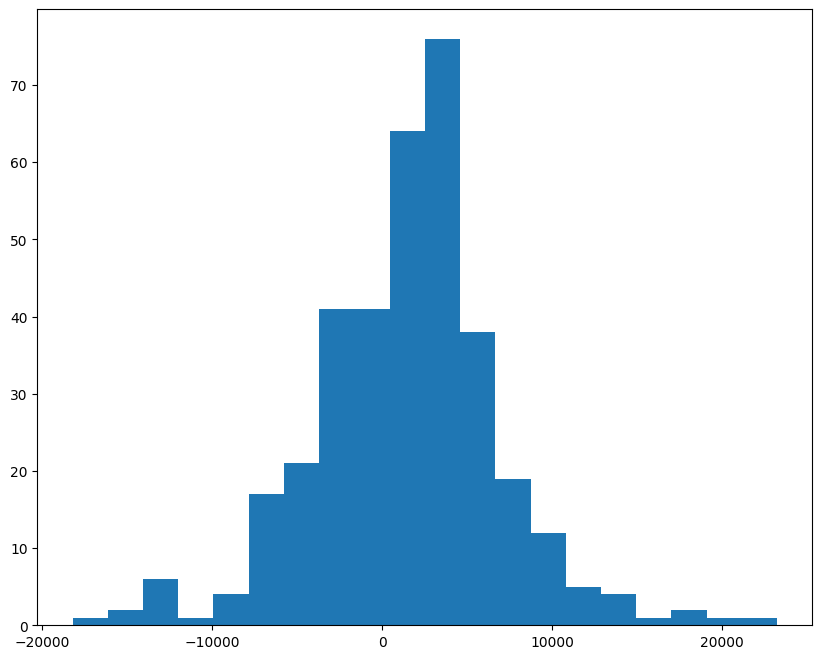

In [53]:
plt.figure(figsize=(10,8))
plt.hist(df['diffs'], bins =20)
plt.show()

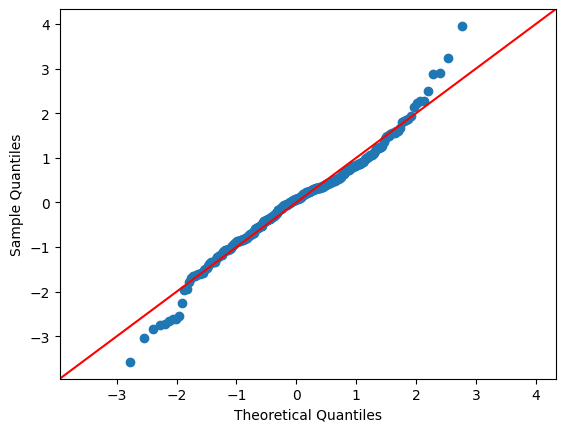

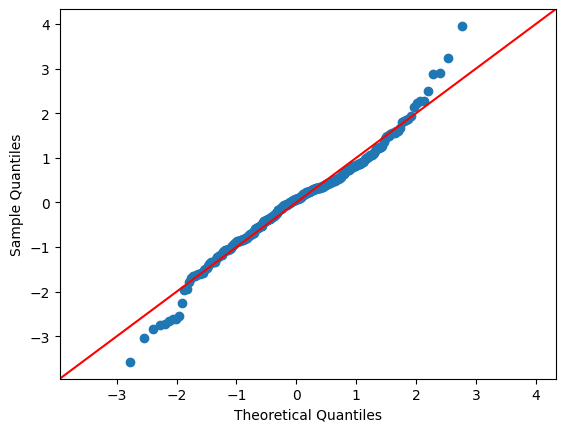

In [54]:
sm.qqplot(df['diffs'], line="45",fit =True)


The histogram seems to be skewed slightly left. The shape of Q-Q plot seems to indicate that there are outliers and seem to outliers which doen't seem to fit the theoretical quantiles. If our data passes the Shapiro-Wilke's test, we should perhaps consider removing outlier differences above a certain threshold.

### Shapiro Wilke's Test for Normality

We chose to use Shapiro Wilke's test for normality to definitively test if the differences between paired step count observations comes from a normal distribution. Our chosen significance level is 0.05.  


In [56]:
print("Shapiro no filter", shapiro(df['diffs']))
print("Shapiro < 25000 filter", shapiro(df[abs(df['diffs']) < 25000]['diffs']))
# Filtered out outliers above a 20000 
print("Shapiro < 20000 filter",shapiro(df[abs(df['diffs']) < 20000]['diffs']))

Shapiro no filter ShapiroResult(statistic=np.float64(0.978538493097911), pvalue=np.float64(3.688217371883432e-05))
Shapiro < 25000 filter ShapiroResult(statistic=np.float64(0.978538493097911), pvalue=np.float64(3.688217371883432e-05))
Shapiro < 20000 filter ShapiroResult(statistic=np.float64(0.9817485199012629), pvalue=np.float64(0.00017582031913550416))


The raw data differences do not come from a normal distribution. Without any filters, the p-value, or the probability that we reject the null hypothesis that the data comes from a normal distribution is $1.21 * 10^{-11}$. However, we can alter the data to fit the normal distribution by putting a filter on the absolute value of the differences. 

We have found that when we filter out outliers above an absolute value of 20000, the p-value rises to 0.166. This is greater than the chosen significance level. 

This alteration is a considerable change to the data. Before immediately jumping into a paired t-test with the altered data, we should consider the effects this would have on the experiment and its data integrity.

### Wilcoxon Signed-Rank Test

Steps:
1. Rank the absolute differences between paired measurements.
2. Sum the ranks of positive and negative differences 
3. Calculate the test statistc as the smaller of the two sum of ranks
4. Compare the calculated test statistic to the critical value from Wilcoxon Signed-Rank Test table.

In [ ]:
# get absolute values
df['absdiffs'] = df['diffs'].apply(lambda x: abs(x))

In [68]:
# sort and reset indices
wdf = df.sort_values(by=["absdiffs"]).reset_index()

# sum indices for each differencd
w_x, w_y = sum(df[df['diffs'] <0].index),sum(df[df['diffs'] >0].index)
w_x, w_y

(26328, 45072)

In [75]:
# Calculate z-score
n = len(df)
mean = ((n+1) * n) / 4 
std = (n*(n+1)*(2*n+1) / 24)**0.5
z_score = (w_x - mean) / std

# calculate cdf
cdf = norm.cdf(z_score)
p = 2 * min(cdf, 1- cdf)

print("Z-score:", z_score, ". CDF:", cdf, ". p-value", p)

Z-score: -2.8819316599544944 . CDF: 0.0019762272354509366 . p-value 0.003952454470901873
